In [1]:
import os
import re
import tqdm
import string
import pandas as pd
import numpy as np
from nltk.corpus import stopwords 
from gensim.models import Doc2Vec
from gensim.models.doc2vec import LabeledSentence
#Gensim is a Python library for *topic modelling*, *document indexing* and *similarity retrieval* with large corpora.
from gensim import utils as gutils
import matplotlib.pyplot as plt
import itertools
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

C:\Users\ahmed\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
def loadData():
    '''
    #loading original data
    @return: 
        all_data, the raw data with 4 fields: [ID, Gene, Variation, Text]
        train_size, 
        test_size
    '''
    train_variant = pd.read_csv("PM/data/training_variants")
    test_variant = pd.read_csv("PM/data/stage2_test_variants.csv")
    train_text = pd.read_csv("PM/data/training_text", sep = "\|\|", engine = 'python', header=None, skiprows=1, names=["ID","Text"])
    test_text = pd.read_csv("PM/data/stage2_test_text.csv", sep = "\|\|", engine = 'python', header=None, skiprows=1, names=["ID","Text"])
    train1 = pd.merge(train_variant, train_text, how = 'inner', on = 'ID')
    #train2 is that we use some labeled 1st stage test data as training data too 
    train2_variant = pd.read_csv("PM/data/test_variants" , names= ["ID", "Gene", "Variant","Class"])
    del(train2_variant["Class"])
    train2_text = pd.read_csv("PM/data/test_text", sep = "\|\|", engine = 'python', header=None, skiprows=1, names=["ID","Text"])
    train2_solution = test_solution = pd.read_csv("PM/data/stage1_solution_filtered.csv", sep = ",")
    train2_id = train2_solution['ID'].values
    train2_tmp = np.array(train2_solution.drop('ID', axis = 1))
    train2_tmp2 = np.argmax(train2_tmp, axis = 1) + 1
    train2 = pd.DataFrame(np.vstack((train2_id, train2_tmp2)).T, columns = ['ID', 'Class'])
    train2 = pd.merge(train2_variant, train2, how = 'inner', on = 'ID')
    train2 = pd.merge(train2, train2_text, how = 'inner', on = 'ID')
    train = pd.DataFrame(np.concatenate((train1, train2), axis=0))
    train.columns = ["ID", "Gene", "Variation", "Class", "Text"]
    train_y = train['Class'].values
    train_y = np.array(train_y, dtype = int)
    train_x = train.drop('Class', axis = 1)
    train_size = len(train_x)
    test_x = pd.merge(test_variant, test_text, how = 'inner', on = 'ID')
    test_size = len(test_x)
    test_index = test_x['ID'].values
    all_data = np.concatenate((train_x, test_x), axis=0)
    all_data = pd.DataFrame(all_data)
    all_data.columns = ["ID", "Gene", "Variation", "Text"]
    #print(all_data.head())
    return [all_data, train_size, test_size, train_x, train_y, test_x]


In [3]:
all_data, train_size, test_size, train_x, train_y, test_x=loadData()

In [4]:
train_y

array([1, 2, 2, ..., 2, 7, 2])

In [5]:
def constructLabeledSentences(data):
    sentences=[]
    for index, row in data.iteritems():
        sentences.append(LabeledSentence(gutils.to_unicode(row).split(), ['Text' + '_%s' % str(index)]))
    return sentences
def constructSentences(data):
    sentences=[]
    for index, row in data.iteritems():
        sentences.append(gutils.to_unicode(row).split())
    return sentences    
def textClean(text):
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = text.lower().split()
    stops = set(stopwords.words("english"))
    sw=set(stopwords.words('english')).union(set(ENGLISH_STOP_WORDS))
    sw= sw.union(set(STOP_WORDS))
    mystopwordlist=set(['fig.', 'references', 'result','go to','preferences', 'results', 'discussion',
                    'methods', 'acknowledgements', 'figure', 'table', 'abstract' ,
                    'background', 'go', 'introduction', 'null', 'author', 'find','found','show','result',
                    'results', 'analyze', 'supplementry','the', 'et','al' ,'al.','also','study',
                    'mutation', 'mutations','cell','gene','mutant','[1]','[2]','[3]','[4]','[5]','[6]','[7]','[8]','[9]'])
    sw|= set(mystopwordlist)
    text = [w for w in text if not w in sw]    
    text = " ".join(text)
    return(text)
    
def cleanup(text):
    text = textClean(text)
   
    text= text.translate(str.maketrans("","", string.punctuation))
    return text


def data_preprocess(all_data):
    '''
    @param all_data, the raw data loaded from loadData() function, containing 4 fields: [ID, Gene, Variation, Text]
    @return 
    '''
    allText = all_data['Text'].apply(cleanup) # a list of str
    sentences = constructLabeledSentences(allText)
    w_sentences= constructSentences(allText)
    return sentences , w_sentences



In [6]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4328 entries, 0 to 4327
Data columns (total 4 columns):
ID           4328 non-null object
Gene         4328 non-null object
Variation    4328 non-null object
Text         4323 non-null object
dtypes: object(4)
memory usage: 135.4+ KB


In [7]:
train_size

3342

In [8]:
test_size

986

In [9]:
all_data.fillna("", inplace=True)

In [10]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4328 entries, 0 to 4327
Data columns (total 4 columns):
ID           4328 non-null int64
Gene         4328 non-null object
Variation    4328 non-null object
Text         4328 non-null object
dtypes: int64(1), object(3)
memory usage: 135.4+ KB


In [11]:
sentences, w_sentences=data_preprocess(all_data)


C:\Users\ahmed\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  after removing the cwd from sys.path.


In [12]:
w_sentences[0]

['cyclindependent',
 'kinases',
 'cdks',
 'regulate',
 'variety',
 'fundamental',
 'cellular',
 'processes',
 'cdk10',
 'stands',
 'orphan',
 'cdks',
 'activating',
 'cyclin',
 'identified',
 'kinase',
 'activity',
 'revealed',
 'previous',
 'work',
 'shown',
 'cdk10',
 'silencing',
 'increases',
 'ets2',
 'vets',
 'erythroblastosis',
 'virus',
 'e26',
 'oncogene',
 'homolog',
 '2',
 'driven',
 'activation',
 'mapk',
 'pathway',
 'confers',
 'tamoxifen',
 'resistance',
 'breast',
 'cancer',
 'cells',
 'precise',
 'mechanisms',
 'cdk10',
 'modulates',
 'ets2',
 'activity',
 'generally',
 'functions',
 'cdk10',
 'remain',
 'elusive',
 'demonstrate',
 'cdk10',
 'cyclindependent',
 'kinase',
 'identifying',
 'cyclin',
 'activating',
 'cyclin',
 'cyclin',
 'm',
 'orphan',
 'cyclin',
 'product',
 'fam58a',
 'cause',
 'star',
 'syndrome',
 'human',
 'developmental',
 'anomaly',
 'features',
 'include',
 'toe',
 'syndactyly',
 'telecanthus',
 'anogenital',
 'renal',
 'malformations',
 'star',


In [13]:
lenlist=[]
for i in range(len(sentences)):
    lenlist.append(len(sentences[i][0]))

In [14]:
lenlist=np.array(lenlist)

In [15]:
max(lenlist)

47557

In [16]:
class Doc2VecParam:
	def __init__(self, min_count=1, window=5, size=200, sample=1e-4, negative=5, workers=4, iter=30, seed=1):
		self.min_count = min_count
		self.window = window
		self.size = size
		self.sample = sample
		self.negative = negative
		self.workers = workers
		self.iter = iter
		self.seed = seed


def Doc2VecWrapper(param):
	text_model = Doc2Vec(min_count=param.min_count, window=param.window, size=param.size, sample=param.sample, negative=param.negative, workers=param.workers, iter=param.iter, seed=param.seed)
	return text_model

In [17]:
from gensim.models import Doc2Vec
from gensim.models import KeyedVectors
from sklearn.decomposition import TruncatedSVD

In [18]:
TEXT_INPUT_DIM=200
#Doc2vec(min_count=1, window=30, size=TEXT_INPUT_DIM, sample=1e-4, negative=5, workers=4, iter=30, seed=1)
param = Doc2VecParam(1, 30, TEXT_INPUT_DIM, 1e-4, 5, 4, 30, 1)
filename='PM/model/doc2vec/docEmbeddings_30_load_all.d2v'
GENE_INPUT_DIM=25
svd = TruncatedSVD(n_components=GENE_INPUT_DIM, n_iter=25, random_state=12)

In [19]:
param.min_count

1

In [20]:
def getTextModel(sentences, param = Doc2VecParam(), filename='', source_file = ''):
    '''
    
    !!!NOT RECOMMENDED!!!
    !!!Use loadTextModel() or trainTextModel() instead!!!
    Get text_model either from pre-trained models or train it using assigned parameters.
    See also util.Doc2VecParam, util.Doc2VecWrapper()
    @param: filename, the path to the 
    @return: text_model for the following
    '''
    if filename == '' or not os.path.isfile(filename):
        print('Creating model...')
        filename = 'PM/model/doc2vec/newModel.d2v'
        if not os.path.isdir("PM/model/doc2vec/"):
            os.mkdir('PM/model/doc2vec')
        
        source_file = "/PM/data/bio_nlp_vec/PubMed-shuffle-win-30.bin"
       # Doc2Vec(min_count=param.min_count, window=param.window, size=param.size, sample=param.sample, negative=param.negative, workers=param.workers, iter=param.iter, seed=param.seed)
        print(param)
        text_model = Doc2VecWrapper(param)
        text_model.build_vocab(sentences)
        try:   
            print("intersecting")
            text_model.intersect_word2vec_format(source_file, binary = True, lockf=0.0)
        except:
            print('Unable to find file: ' + source_file)
            return ''
        text_model.train(sentences, total_examples=text_model.corpus_count, epochs=text_model.iter)
        text_model.save(filename)
        print('successfully created the Text Model and save it to ' + filename)
        
    else:
        text_model = loadTextModel(filename)
    return text_model



In [21]:
def loadTextModel(filename = ''):
    if filename == '' or not os.path.isfile(filename):
        print('Unable to find file: ' + filename)
        return
    try:
        text_model = Doc2Vec.load(filename)
    except:
        print('Text Model file exists but unable to load.')
        return
    print('Successfully loaded the textmodel from ' + filename)
    return text_model



In [22]:
def trainTextModel(sentences, param, modelName, PATH = 'PM/model/doc2vec/', outside = False, source_file = ''):
    if not os.path.isdir(PATH):
        os.mkdir(PATH)
    text_model = Doc2VecWrapper(param)
    text_model.build_vocab(sentences)
    if(outside):
        try:
            text_model.intersect_word2vec_format(source_file, binary = True, lockf = 0.0)
        except:
            print("Unable to load outside file: " + source_file)
            return None
    text_model.train(sentences, total_examples=text_model.corpus_count, epochs=text_model.iter)
    print('Successfully trained the text model!')
    text_model.save(PATH + modelName)
    print('Save the model to: ' + PATH)
    return text_model





In [23]:
def getTextVec(text_model, train_size, test_size, TEXT_INPUT_DIM = 200):
    '''
    Get the clinical text vector representation based on the text_model
    @param: 
        text_model,
        train_size,
        test_size,
        TEXT_INPUT_DIM, set to 200 as default
    @return:
        text_train_arrays, text vector in training set
        text_test_arrays, ... in test set
    '''
    text_train_arrays = np.zeros((train_size, TEXT_INPUT_DIM))
    text_test_arrays = np.zeros((test_size, TEXT_INPUT_DIM))
    for i in range(train_size):
        text_train_arrays[i] = text_model.docvecs['Text_'+str(i)]
    j = 0
    for i in range(train_size, test_size + train_size):
        text_test_arrays[j] = text_model.docvecs['Text_'+str(i)]
        j += 1
    return text_train_arrays, text_test_arrays




In [24]:
def getGeneVec(all_data, svd):
    '''
    Get the vector representation for the Gene, the length of the vector is compressed by SVD with default input dimension 25
    @param: 
        all_data,
        svd, TruncatedSVD model from sklearn
    @return: truncated_one_hot_gene, gene vector representation
    '''
    one_hot_gene = pd.get_dummies(all_data['Gene'])
    truncated_one_hot_gene = svd.fit_transform(one_hot_gene.values)
    return truncated_one_hot_gene




In [25]:
def getVariationVec(all_data, svd):
    '''
    Get the vector representation for the variation type, the length of the vector is compressed by SVD with default input dimension 25
    @param: 
        all_data,
        svd, TruncatedSVD model from sklearn
    @return: truncated_one_hot_variation, variation vector representation
    '''
    one_hot_variation = pd.get_dummies(all_data['Variation'])
    truncated_one_hot_variation = svd.fit_transform(one_hot_variation.values)
    return truncated_one_hot_variation


    


In [26]:
TEXT_INPUT_DIM=200
GENE_INPUT_DIM=25
param1 = Doc2VecParam(1, 5, TEXT_INPUT_DIM, 1e-4, 5, 4, 30, 1)
filename='PM/model/doc2vec/docEmbeddings_30_load_all.d2v'




In [27]:
param1.min_count

1

In [28]:
svd = TruncatedSVD(n_components=25, n_iter=GENE_INPUT_DIM, random_state=12)
#trainTextModel(sentences=all_data, param, modelName, PATH = 'PM/model/doc2vec/', outside = False, source_file = '')
#text_model = getTextModel(sentences=sentences,param=param1, filename=filename)
text_model= trainTextModel(sentences=sentences, param=param1, modelName="d2v", PATH='PM/model/doc2vec', outside=False, source_file="/PM/data/bio_nlp_vec/PubMed-shuffle-win-30.bin")


C:\Users\ahmed\Anaconda3\envs\tf_gpu\lib\site-packages\gensim\models\doc2vec.py:570: UserWarning: The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.
  warnings.warn("The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.")
C:\Users\ahmed\Anaconda3\envs\tf_gpu\lib\site-packages\gensim\models\doc2vec.py:574: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
C:\Users\ahmed\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  if sys.path[0] == '':


Successfully trained the text model!
Save the model to: PM/model/doc2vec


In [29]:
text_model.docvecs 

In [30]:
truncated_one_hot_gene = getGeneVec(all_data, svd)
truncated_one_hot_variation = getVariationVec(all_data, svd)
text_train_arrays, text_test_arrays = getTextVec(text_model, train_size, test_size, TEXT_INPUT_DIM)

train_set = np.hstack((truncated_one_hot_gene[:train_size], truncated_one_hot_variation[:train_size], text_train_arrays))
# N by (25+25+200)
test_set = np.hstack((truncated_one_hot_gene[train_size:], truncated_one_hot_variation[train_size:], text_test_arrays))


In [33]:
from collections import Counter
count_dict=Counter(train_y)

In [34]:
count_dict

Counter({1: 573, 2: 458, 3: 90, 4: 690, 5: 242, 6: 275, 7: 957, 8: 19, 9: 38})

In [31]:
train_set.shape

(3342, 250)

In [32]:
train_set

array([[ 1.73611010e-25,  3.58690205e-21, -1.40850001e-20, ...,
         1.41942894e+00, -1.96650362e+00,  2.46603251e+00],
       [ 2.52191182e-20,  7.78400194e-16,  1.11617132e-15, ...,
        -5.50434113e-01, -1.00871956e+00,  1.02565956e+00],
       [ 2.52241181e-20,  7.78615660e-16,  1.11035021e-15, ...,
        -1.06636548e+00, -7.39341736e-01,  9.64324057e-01],
       ...,
       [ 1.00000000e+00, -3.18087825e-19, -6.55733015e-21, ...,
         3.42455387e-01,  1.25420904e+00,  1.79430461e+00],
       [ 1.99552134e-36, -6.61759200e-33, -1.21882352e-32, ...,
         1.90345490e+00,  5.13853040e-03,  3.10508877e-01],
       [-8.76012426e-25, -9.53274212e-21, -1.36561295e-20, ...,
         1.89722061e+00, -1.41675174e+00,  1.23925436e+00]])

In [35]:
from imblearn.over_sampling import SMOTE 
sm = SMOTE(random_state = 2) 
X_train_res, y_train = sm.fit_sample(train_set, train_y) 

Using TensorFlow backend.
C:\Users\ahmed\Anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ahmed\Anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ahmed\Anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\ahmed\Anaconda3\envs\tf_gpu\lib\sit

In [37]:
X_train_res.shape

(8613, 250)

In [38]:
from collections import Counter
count_dict=Counter(y_train)

In [39]:
count_dict

Counter({1: 957,
         2: 957,
         3: 957,
         4: 957,
         5: 957,
         6: 957,
         7: 957,
         8: 957,
         9: 957})

In [40]:
encoded_y = pd.get_dummies(y_train)
encoded_y = np.array(encoded_y)

In [59]:
encoded_y.shape

(8613, 9)

In [90]:
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding,LSTM,Flatten
from keras import optimizers
from keras.callbacks import EarlyStopping


In [36]:
def nn_baseline_model(Text_INPUT_DIM = 200, Gene_INPUT_DIM = 25, Variation_INPUT_DIM = 25):
    model = Sequential()
    model.add(Dense(256, input_dim=Text_INPUT_DIM+ Gene_INPUT_DIM + Variation_INPUT_DIM, init='normal', activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(256, init='normal', activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(80, init='normal', activation='relu'))
    model.add(Dense(9, init='normal', activation="softmax"))
    
    #optimizer = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True) original type
    #optimizer = optimizers.Adadelta(lr=0.5, rho=0.95, epsilon=1e-08, decay=0.0) 
    optimizer = optimizers.Adam(lr=0.001) 
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [128]:
def lstm_baseline_model(r,c):
  
    lstm_out = 250
    model = Sequential()
    model.add(LSTM(lstm_out,return_sequences=True, dropout=0.6, input_shape=(1, c)))
    model.add(LSTM(lstm_out,return_sequences=True, dropout=0.6, input_shape=(1, c)))
    model.add(LSTM(200,return_sequences=True, dropout=0.6, input_shape=(1, c)))
    model.add(LSTM(200,return_sequences=True, dropout=0.6, input_shape=(1, c)))
    model.add(Dropout(0.3))
    model.add(Dense(128, init='normal', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, init='normal', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, init='normal', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, init='normal', activation='relu'))
    model.add(Dropout(0.08))
    model.add(Flatten())
    
    model.add(Dense(9, init='normal', activation="softmax"))
    #adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
    return model 

In [129]:
model=lstm_baseline_model(X_train_res.shape[0],X_train_res.shape[1])
model.summary()

C:\Users\ahmed\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(128, activation="relu", kernel_initializer="normal")`
  # Remove the CWD from sys.path while we load stuff.
C:\Users\ahmed\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(128, activation="relu", kernel_initializer="normal")`
  if sys.path[0] == '':
C:\Users\ahmed\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(128, activation="relu", kernel_initializer="normal")`
  
C:\Users\ahmed\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(64, activation="relu", kernel_initializer="normal")`
  app.launch_new_instance()
C:\Users\ahmed\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:20: UserWarning

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 1, 250)            501000    
_________________________________________________________________
lstm_18 (LSTM)               (None, 1, 250)            501000    
_________________________________________________________________
lstm_19 (LSTM)               (None, 1, 200)            360800    
_________________________________________________________________
lstm_20 (LSTM)               (None, 1, 200)            320800    
_________________________________________________________________
dropout_22 (Dropout)         (None, 1, 200)            0         
_________________________________________________________________
dense_23 (Dense)             (None, 1, 128)            25728     
_________________________________________________________________
dropout_23 (Dropout)         (None, 1, 128)            0         
__________

In [51]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [130]:
folds= StratifiedKFold(n_splits=10,shuffle=True, random_state=999)


In [ ]:
X_train_reshaped= np.reshape(X_train_res, (X_train_res.shape[0],1,X_train_res.shape[1]))

In [106]:
test_set1=[]
test_set2=[]
test_set3=[]
test_set4=[]
test_set5=[]
i=1
for train_index, test_index in folds.split(X_train_reshaped, y_train):
    if i==1:
        test_set1=test_index
    elif i==2:
        test_set2=test_index
    elif i==3:
        test_set3=test_index
    elif i==4:
        test_set4=test_index
    elif i==5:
        test_set5=test_index
    
    i=i+1
    
    print(train_index.shape, test_index.shape)
    for item in test_index:
        if(item in train_index):
            print("true")
    
    

(7751,) (862,)
(7751,) (862,)
(7751,) (862,)
(7752,) (861,)
(7752,) (861,)
(7752,) (861,)
(7752,) (861,)
(7752,) (861,)
(7752,) (861,)
(7752,) (861,)


In [57]:
set(test_set2)& set(test_set1)

set()

In [131]:
def train_nn_model(model, train_set, encoded_y,train_y, filename = ''):  #best_weight_predict_all.h5
    if os.path.isfile(filename):
        model.load_weights(filename)
        print('successful load\n')
    else:
        print('begin training\n')
        best_acc = 0
        acc = []
        val_acc = []
        
        loss = []
        val_loss = []
        for train_index, test_index in folds.split(train_set, train_y):
            X_train, X_test, Y_train, Y_test = train_set[train_index], train_set[test_index], encoded_y[train_index], encoded_y[test_index]
            
            
            for i in range(1):
                #estimator=model.fit(train_set, encoded_y, validation_split=0.1, epochs=2, batch_size=64
                
                estimator=model.fit(X_train, Y_train, validation_data=(X_test, Y_test), callbacks=[monitor],epochs=1000, batch_size=64, verbose=0)
                if (best_acc < estimator.history['val_acc'][-1] * 100):
                    best_acc = estimator.history['val_acc'][-1] * 100
                    model.save_weights(filename)
                print("Training accuracy: %.2f%% / Best validation accuracy: %.2f%%" % (100*estimator.history['acc'][-1], best_acc))
                acc += estimator.history['acc']
                val_acc += estimator.history['val_acc']
                loss += estimator.history['loss']
                val_loss += estimator.history['val_loss']
            
        #plot the history for loss and accuracy
        plt.plot(acc)
        plt.plot(val_acc)
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'valid'], loc='upper left')
        plt.show()
        plt.plot(loss)
        plt.plot(val_loss)
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'valid'], loc='upper left')
        plt.show()
    return model

In [82]:
#model = nn_baseline_model(TEXT_INPUT_DIM, GENE_INPUT_DIM, GENE_INPUT_DIM)
#model.summary()

In [83]:
#6folds= StratifiedKFold(n_splits=10,shuffle=True, random_state=999)


In [108]:
X_train_reshaped.shape

(8613, 1, 250)

In [109]:
train_y

array([1, 2, 2, ..., 2, 7, 2])

In [132]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto',
        restore_best_weights=True)

begin training

Restoring model weights from the end of the best epoch
Epoch 00044: early stopping
Training accuracy: 68.55% / Best validation accuracy: 71.23%
Restoring model weights from the end of the best epoch
Epoch 00023: early stopping
Training accuracy: 71.71% / Best validation accuracy: 76.68%
Restoring model weights from the end of the best epoch
Epoch 00009: early stopping
Training accuracy: 71.75% / Best validation accuracy: 77.26%
Restoring model weights from the end of the best epoch
Epoch 00011: early stopping
Training accuracy: 72.63% / Best validation accuracy: 77.26%
Restoring model weights from the end of the best epoch
Epoch 00009: early stopping
Training accuracy: 72.99% / Best validation accuracy: 78.05%
Restoring model weights from the end of the best epoch
Epoch 00011: early stopping
Training accuracy: 73.65% / Best validation accuracy: 80.72%
Restoring model weights from the end of the best epoch
Epoch 00006: early stopping
Training accuracy: 73.56% / Best vali

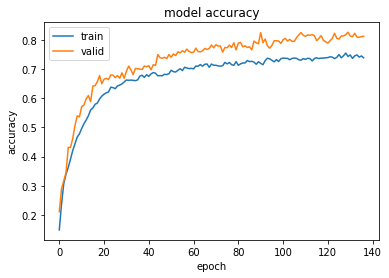

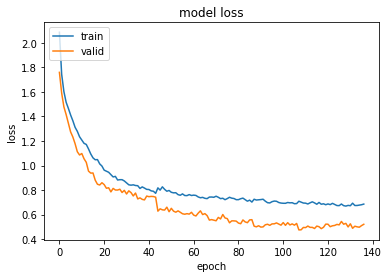

In [134]:
#for train_index, test_index in folds.split(train_set, train_y):
 #   X_train, X_test, Y_train, Y_test = train_set[train_index], train_set[test_index], encoded_y[train_index], encoded_y[test_index]
    
    
    
model = train_nn_model(model, X_train_reshaped, encoded_y,y_train, filename = 'demo_NN.h5' )

In [97]:
test_set_reshaped= np.reshape(test_set, (test_set.shape[0],1,test_set.shape[1]))

In [135]:

#model = train_nn_model(model, train_set, encoded_y, filename = 'demo_NN.h5' ) #demo_NN.h5
y_predict = model.predict_proba(test_set_reshaped)

In [136]:
y_predict.shape


(986, 9)

In [137]:
def savesubmission(pred, test_x, filename = "submission_all.csv"):
    submission = pd.DataFrame(pred)
    submission.insert(0, 'ID', test_x['ID'])
    submission.columns = ['ID','class1', 'class2', 'class3', 'class4', 'class5', 'class6', 'class7', 'class8', 'class9']
    submission.to_csv(filename,index=False)
    submission.head()

In [138]:
savesubmission(y_predict, test_x, filename = "to_submit_2.csv")